In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


## Training and test data

In [3]:

# cancer_type_columns = [
#    "Neoplasm Disease Stage American Joint Committee on Cancer Code", 
#    "Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage", 
#    "American Joint Committee on Cancer Metastasis Stage Code", 
#    "American Joint Committee on Cancer Lymph Node Stage Code.1", 
#    "American Joint Committee on Cancer Lymph Node Stage Code", 
#    "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code", 
#    "Neoplasm Disease Stage American Joint Committee on Cancer Code.1", 
#    "American Joint Committee on Cancer Publication Version Type", 
#    "American Joint Committee on Cancer Tumor Stage Code"
# ]

newFields = [
   "Cancer Type Detailed", 
   "Fraction Genome Altered", 
   "Mutation Count", 
   "Sample Initial Weight", 
   "TMB (nonsynonymous)"
]

pd_df_original = pd.read_csv(
    "./Testicular Cancer Dataset.csv",
    usecols=[*newFields, 'Disease Free (Months)', 'Postoperative tx']#, 'Disease Free Status']
)

pd_df_original = pd_df_original.dropna()

pd_df = pd_df_original.copy()

# target = pd_df.apply(lambda p: p['Disease Free (Months)'] * (1 if p['Disease Free Status'] == '1:Recurred/Progressed' else 1), axis=1)

target = pd_df.pop('Disease Free (Months)')
# pd_df.pop('Disease Free Status')

# target = np.log2(target)

inputs = {}

for name, column in pd_df.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

# Vi har ingen numeric inputs pr no
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}
x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(pd_df_original[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(pd_df[name]))
  one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

# preprocessed_inputs

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# Nå visualiserings greie
# tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)


# Split training og testing data
# Random state 5 e dårlig, 19 og 4 e ganske bra, 2 e hinsides bra!
random_state=2

train_input, test_input = train_test_split(pd_df, test_size=0.2, random_state=random_state)
train_output, test_output = train_test_split(target, test_size=0.2, random_state=random_state)

train_input = {name: np.array(value) for name, value in train_input.items()}
test_input = {name: np.array(value) for name, value in test_input.items()}

# Must split my_features_dict into training and testing data
# Split on the same indexes with target, my_features_dict[0] corresponds to target[0] and so on

def model_func(preprocessing, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(1)
    ])

    preprocessed_inputs = preprocessing(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        optimizer=tf.keras.optimizers.legacy.Adam()
    )
    return model

model = model_func(preprocessing, inputs)

In [153]:
model.fit(x=train_input, y=train_output, epochs=50, verbose=1)

Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 95.6271
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 92.5502
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 89.4730
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 86.4745
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 83.8578
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 81.9930
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 79.7645
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 77.8289
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 75.9474
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 73.9590
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 72.0940
Epoch 12/50
3/3 [==============================] - 0s 1ms/step - loss: 70.5446
Epoch 13/50
3/3 [==============================] - 0s 2ms/ste

In [151]:
model.evaluate(test_input, test_output)

1/1 [==============================] - 0s 24ms/step - loss: 97.0450


97.04496765136719

Using random_state:  2
1/1 [==============================] - 0s 20ms/step - loss: 119.6213


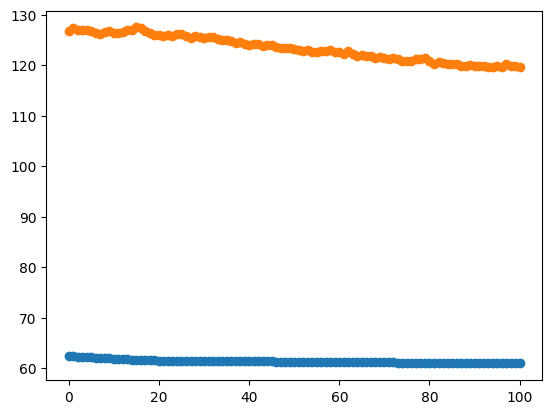

In [5]:
results = []

print('Using random_state: ', random_state)

results.append((model.evaluate(train_input, train_output), model.evaluate(test_input, test_output)))
for i in range(100):
    model.fit(x=train_input, y=train_output, epochs=10, verbose=0)
    results.append((model.evaluate(train_input, train_output), model.evaluate(test_input, test_output)))

fig, ax = plt.subplots()
# ax.plot(range(100), modelResTo100)
ax.plot([r[0] for r in results], 'o')
ax.plot([r[1] for r in results], 'o')

plt.show()